## What CPU and GPU am I using?

Before we start, lets check what processor and GPU we will be using. Performance can vary a lot depending on which model we are using. Google Collab does not allow us to choose the model, but it is free.

In [ ]:
!echo "CPU:"
!cat /proc/cpuinfo | grep name
!echo "GPU:"
!nvidia-smi

CPU:
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
GPU:
Wed Jan 26 08:47:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--------------

## Matrix Multiplication

We start by importing numpy and numba. We also define a checksum function as a fast checking mechanism. **In this case, we use as checksum the sum of all elements divided by N^2, where N is the dimension of the matrix. Other types of checksum could be implemented.**

**We will assume that we have a square matrix (N x N).** 

In [1]:
# conda install numba cudatoolkit=10.1
import time
import numpy as np
from numpy.random import seed
from numpy.random import rand
from numba import jit,njit,prange,cuda, types, float32
import matplotlib.pyplot as plt

%matplotlib inline 

# Randomize between -10, 10
def randomize_array(size):
    return 10.0 * 1.0 * (rand(size) - 0.5)

# Randomize two matrices a and b and set matrix c to zeros
def init(size):
    seed(1)
    size_sq = size*size
    a = np.array(randomize_array(size_sq), dtype=np.float32)
    b = np.array(randomize_array(size_sq), dtype=np.float32)
    c = np.zeros(size_sq, dtype=np.float32)
    return a, b, c

# Compile and run the check in parallel with Numba
# (we do this to keep this part fast, but it is not the main objective of the execise)
@njit(parallel = True)
def check(c):
    size = len(c)
    sum = 0.0
    for i in prange(size):
        sum += c[i]
    return sum

# Helper function
def time_and_check(matrix_multiply_func, size):
    a, b, c = init(size)

    start = time.time()
    matrix_multiply_func(a, b, c, size)
    end = time.time()

    print('Size: ', size, ' elapsed time: ',end-start, ' checksum = ', check(c))

    return end-start

### Interpreted Matrix Multiplication

Next, we implement the standard matrix-multiplication algorithm. With the current matrix size N=256*256, it takes about 15s to complete.

In [2]:
def mat_mul_base(a,b,c,size):
    for i in range(size):
        for j in range(size):
            for k in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]

In [ ]:
time_and_check(mat_mul_base, 256)

Size:  256  elapsed time:  6.608009099960327  checksum =  888.3061476051807


6.608009099960327

### Compiled Matrix Multiplication

Python is an interpreted language, which means standard loops like these are very, very slow...

Fortunately, we can use numba to compile this kernel just-in-time. The performance will be comparable to C or FORTRAN code!
It should take less than a second with the same matrix size.

In [3]:
@njit
def mat_mul_numba(a,b,c,size):
    for i in range(size):
        for j in range(size):
            for k in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]

In [ ]:
time_and_check(mat_mul_numba, 256)

Size:  256  elapsed time:  0.11964941024780273  checksum =  888.3061476051807


0.11964941024780273

We are going to optimize this code a lot. So from now on, we will use a much larger matrix size. Let's try again. This should take less than 1 min.

In [ ]:
time_and_check(mat_mul_numba, 2048)

Size:  2048  elapsed time:  54.29975509643555  checksum =  -354899.36132545955


54.29975509643555

### Cache efficiency

The standard implementation that we have above, with loops on i, j, k is actually not very cache-friendly. It accesses memory cells that are always very far apart in memory. A well-known trick is to switch the k and j loop so that most memory accesses become continous in memory for matrix c and b. This **greatly** improves cache-efficiency, and performance. See by yourself!

In [4]:
@njit
def mat_mul_numba_opt(a,b,c,size):
    for i in range(size):
        for k in range(size):  # We just switched j and k
            for j in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]

In [ ]:
time_and_check(mat_mul_numba_opt, 2048)

Size:  2048  elapsed time:  12.088269710540771  checksum =  -354899.36132545955


12.088269710540771

Size:  64  elapsed time:  0.1046445369720459  checksum =  1106.132840871811
Size:  64  elapsed time:  0.08286237716674805  checksum =  1106.132840871811
Size:  128  elapsed time:  0.0033261775970458984  checksum =  -7402.82864561677
Size:  128  elapsed time:  0.0028541088104248047  checksum =  -7402.82864561677
Size:  192  elapsed time:  0.01038813591003418  checksum =  -19974.804617151618
Size:  192  elapsed time:  0.009840250015258789  checksum =  -19974.804617151618
Size:  256  elapsed time:  0.025287151336669922  checksum =  888.3061476051807
Size:  256  elapsed time:  0.023116350173950195  checksum =  888.3061476051807
Size:  320  elapsed time:  0.04798698425292969  checksum =  -53251.43580004573
Size:  320  elapsed time:  0.04504060745239258  checksum =  -53251.43580004573
Size:  384  elapsed time:  0.10730242729187012  checksum =  45490.72572735697
Size:  384  elapsed time:  0.07788848876953125  checksum =  45490.72572735697
Size:  448  elapsed time:  0.14063334465026855  checks

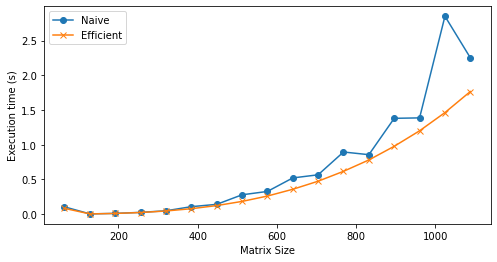

In [25]:
naive = []
efficient = []
sizes = np.arange(64, 1152, 64)
    
for size in sizes:
    naive.append(time_and_check(mat_mul_numba, size))
    efficient.append(time_and_check(mat_mul_numba_opt, size))

plt.figure(figsize=(8,4))
plt.plot(sizes, naive, marker='o', markevery=1, label='Naive')
plt.plot(sizes, efficient, marker='x', markevery=1, label='Efficient')
plt.legend(loc='upper left')
plt.xlabel('Matrix Size')
plt.ylabel('Execution time (s)')
plt.draw()

plt.show()

### Parallelization on CPU

**Note: Google Collab only let you use one CPU, so you will not benefit from parallelization.**

To have a fair comparison with the GPU code that we are going to see in the next section, we can parallelize the CPU code. With 8 CPU cores, the code sould run ~8 times faster.
This will be our baseline code to compare against the GPU code!

In [5]:
@njit(parallel = True)   # we add the option parallel=True to enable threading
def mat_mul_numba_opt_parallel(a,b,c,size):
    for i in prange(size):  # we use prange instead of range. This is the loop being parallelized.
        for k in range(size):
            for j in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]

In [27]:
time_and_check(mat_mul_numba_opt_parallel, 2048)

Size:  2048  elapsed time:  2.0680127143859863  checksum =  -354899.36132545955


2.0680127143859863

### GPU CUDA implementation: EXERCISE

You can try your hands at GPU programming here. Try to answer the following questions and fill the blanks in the code below.

**What does a CUDA thread compute?**

**Hint: our function has three nested loops. Which loop(s) will be executed in parallel? Which loop(s) can you safely break apart and execute independently in parallel?**

<details>
<summary>Answer (toggle)</summary>

**Each thread will compute the inner k loop of the previous code.**

In other word, each thread will compute the dot product between column **i** of matrix **a** and row **j** of matrix **b**.

In fact, we don't need the loops on i and j anymore, because **we have one thread per i,j corrdinate**.
Note that inside the kernel, a thread knows what cell to compute by fetching its coordinates in the grid. This is the only way to differentiate two threads apart!
</details>

**What is the block size?**

<details>
<summary>Answer (toggle)</summary>

**Between 4x4 and 32x32.**

We must specify the block size, a.k.a **the number of threads per block per dimension**. This must be a **multiple of 32**, and the optimal value will vary by code and by architecture. The upper limit is somwhere around 1024 and 4096, which amounts to 32\*32 to 64\*64 for two-dimensional blocks.

Remember that we are working with 2D blocks here, because this better suit us. We define a block of threads to be 16\*16 = 256 threads. Therefore, we will have 256 threads per block.
Feel free to try different **threads per block (TPB)** values below! This can greatly affect performance.
</details>

**What is the grid size?**

<details>
<summary>Answer (toggle)</summary>

**MATRIX_SIZE / BLOCK_SIZE.**

Now that we have defined the block size, we can compute the grid size. Remember, we want the grid size to be at least 2048\*2048 threads. However, the size of the grid must be given in number of blocks. Therefore, we can simply define:
- grid_size = mat_size / TPB = 2048 / 16 = 128 blocks in one dimension.

And the grid has grid_size\*grid_size = 128\*128 = 16384 blocks of threads in total.

Note that our grid indeed has exactly 16384 \* 256  = 2048 \* 2048 threads.
</details>

**How to launch the kernel?**

We launch the CUDA kernel by passing our number of gridsize and blocksize. The GPU will dispatch the blocks to its streaming multiprocessors where they will be executed in locksteps of 32 threadsalso known as warping.

**How fast is it?**

Let's try it out!

In [19]:
@cuda.jit
def mat_mul_numba_cuda(a,b,c,size):
    i=cuda.blockIdx.y*cuda.blockDim.y+cuda.threadIdx.y
    j=cuda.blockIdx.x*cuda.blockDim.x+cuda.threadIdx.x
    
    if i >= size or j >= size:
        return
    
    for k in range(size):
        c[i*size+j]+=a[i*size+k]*b[k*size+j]

In [20]:
# Calling our CUDA kernel is done by passing the number of blocks and number of threads per blocks as follows:
#
#   mat_mul_numba_cuda[gridsize, blocksize](a, b, c, size)
# 
# We can still use our helper function.

for TPB in [4, 8, 16, 32]:
    print('TPB = ', TPB)
    blocksize = (TPB,TPB)
    gridsize = (int(2048/TPB),int(2048/TPB))
    time_and_check(mat_mul_numba_cuda[gridsize, blocksize], 2048)
    time_and_check(mat_mul_numba_cuda[gridsize, blocksize], 2048)


TPB =  4


/home/acavelan/.local/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Size:  2048  elapsed time:  0.3853790760040283  checksum =  -354899.5117803425
Size:  2048  elapsed time:  0.2638392448425293  checksum =  -354899.5117803425
TPB =  8
Size:  2048  elapsed time:  0.16428685188293457  checksum =  -354899.5117803425
Size:  2048  elapsed time:  0.1707451343536377  checksum =  -354899.5117803425
TPB =  16
Size:  2048  elapsed time:  0.08355116844177246  checksum =  -354899.5117803425
Size:  2048  elapsed time:  0.08948755264282227  checksum =  -354899.5117803425
TPB =  32
Size:  2048  elapsed time:  0.0924220085144043  checksum =  -354899.5117803425
Size:  2048  elapsed time:  0.083770751953125  checksum =  -354899.5117803425


### Performance

This should be pretty fast! Note that the time here includes the time needed to copy matrices a and b to the GPU, and then matrix c back to the cpu. Transferring data is often a major bottlneck on the GPU. The execution of the kernel itself is often much faster.

Because the complexity of the matrix-matrix multiplication is O(n^3), the number of computations grow much faster compared to the amount of memory required O(n).

**One can expect the GPU to perform better than the CPU with larger matrix sizes.**

Let's see if this is true!

Size:  64  elapsed time:  0.30948758125305176  checksum =  1106.132840871811
Size:  64  elapsed time:  0.0013585090637207031  checksum =  1106.1321327807382
Matrix size: 64 GPU speed-up: 227.81414531414532
Size:  128  elapsed time:  0.0005254745483398438  checksum =  -7402.82864561677
Size:  128  elapsed time:  0.0009441375732421875  checksum =  -7402.8303683619015
Matrix size: 128 GPU speed-up: 0.5565656565656566
Size:  256  elapsed time:  0.0035028457641601562  checksum =  888.3061476051807
Size:  256  elapsed time:  0.0022852420806884766  checksum =  888.3016443353845
Matrix size: 256 GPU speed-up: 1.532811684924361
Size:  512  elapsed time:  0.027197599411010742  checksum =  107357.05408896133
Size:  512  elapsed time:  0.0030236244201660156  checksum =  107357.06020015624
Matrix size: 512 GPU speed-up: 8.995032329285602


/home/acavelan/.local/lib/python3.10/site-packages/numba/cuda/compiler.py:724: NumbaPerformanceWarning: Grid size (16) < 2 * SM count (56) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/acavelan/.local/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Size:  1024  elapsed time:  0.23289251327514648  checksum =  -602503.9098478667
Size:  1024  elapsed time:  0.015110015869140625  checksum =  -602503.8845218826
Matrix size: 1024 GPU speed-up: 15.413121686442818
Size:  2048  elapsed time:  1.8608264923095703  checksum =  -354899.36132545955
Size:  2048  elapsed time:  0.09626102447509766  checksum =  -354899.5117803425
Matrix size: 2048 GPU speed-up: 19.33104807949513


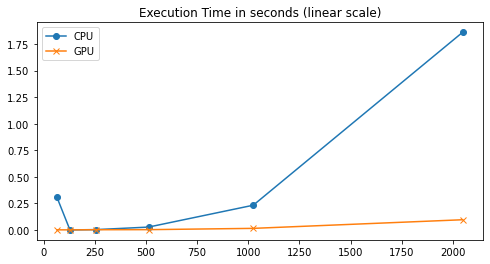

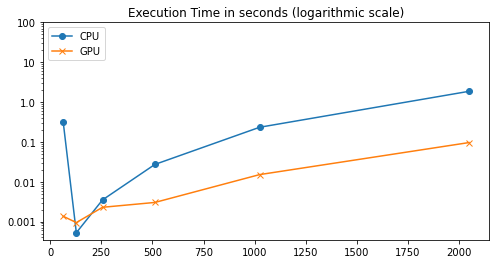

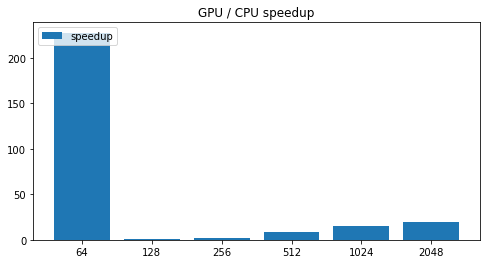

In [21]:
cpu_times = []
gpu_times = []
speedups = []

TPB = 16

sizes = [64, 128, 256, 512, 1024, 2048]#, 4096]
for size in sizes:
    # CPU
    cpu_elapsed_time = time_and_check(mat_mul_numba_opt_parallel, size)
    cpu_times.append(cpu_elapsed_time)
    
    # GPU
    blocksize = (TPB,TPB)
    gridsize = (int(size/TPB),int(size/TPB))
    gpu_elapsed_time = time_and_check(mat_mul_numba_cuda[gridsize, blocksize], size)
    gpu_times.append(gpu_elapsed_time)
    
    speedups.append(cpu_elapsed_time / gpu_elapsed_time)
    print('Matrix size:', size, 'GPU speed-up:', cpu_elapsed_time / gpu_elapsed_time)

plt.figure(figsize=(8,4))
plt.plot(sizes, cpu_times, marker='o', markevery=1, label='CPU')
plt.plot(sizes, gpu_times, marker='x', markevery=1, label='GPU')
plt.legend(loc='upper left')
plt.title('Execution Time in seconds (linear scale)')
plt.draw()

plt.figure(figsize=(8,4))
plt.semilogy(sizes, cpu_times, marker='o', markevery=1, label='CPU')
plt.semilogy(sizes, gpu_times, marker='x', markevery=1, label='GPU')
plt.legend(loc='upper left')
plt.yticks([0.001, 0.01, 0.1, 1.0, 10, 100],[0.001, 0.01, 0.1, 1.0, 10, 100])
plt.title('Execution Time in seconds (logarithmic scale)')
plt.draw()

plt.figure(figsize=(8,4))
plt.bar(np.arange(0,len(speedups)), speedups, label='speedup')
plt.legend(loc='upper left')
plt.xticks(np.arange(0,len(speedups)), sizes)
plt.title('GPU / CPU speedup')
plt.draw()

plt.show()

### How to interpret the results

**First plot:** You should see three plots. The first plot shows the execution time (how long it took to execute the matrix-multiplication in seconds) for different matrix sizes from 64x64 to 2048x2048. As you can see, it took a lot longer for the CPU to compute the largest matrix-sizes. The GPU was always able to finish the computation in under 2 seconds!

 **Second plot:** This exactly the same thing, but now on a logarithmic scale for the y axis. The logarithmic scale is useful when comparing very different numbers! Indeed, now it is clear that even though the GPU is always fast, it also needs more time to compute larger matrix sizes. In fact, this plot shows that the GPU is about 1 to 2 orders of magnitude (10x-100x) faster than the CPU for this task! 

**Third plot:** This is the ratio CPU_TIME / GPU_TIME. This is exactly how much faster the GPU is compared to the CPU. It shows that not only the GPU is much faster than the CPU, it is also more efficient with largest matrix sizes! One reason for this is simple: you need a fixed time to send the data to/from the GPU, which scales linearly O(n). However, the amount of computations scales as O(n^3). Simply put: with largest matrix sizes, we spend more time doing computation and less time copying data, which result in a more efficient use of our time, which makes the GPU even better than the CPU for this task!


## Further optimizations: using shared memory (advanced)

Below we define a block matrix-matrix multiplication algorithm to help reduce the number of accesses to the global GPU memory. CUDA provides a fast shared memory for threads in a block to cooperately compute on a task. 

Matrix a and b are divided into blocks of size `TPB*TPB`, where TPB is also the number of threads per cuda block. Here we define TPB = 16, which means there will be `16*16 = 256` threads per cuda block.

In each loop, we do the following:
* Because the shared memory is a limited resources, the code preloads a small block at a time from the input arrays. It calls syncthreads() to wait until all threads have finished preloading and before doing the computation on the shared memory.
```
for i in range(bpg):
    # Preload data into shared memory
    sA[ty * TPB + tx] = a[(ty + i * TPB) * size + x]
    sB[ty * TPB + tx] = b[y * size + tx + i * TPB]
```
This fills the local shared memory with the corresponding block values from the global GPU memory.

* Next, all of our 256 threads will execute the following instructions:
```
# Computes partial product on the shared memory
for j in range(TPB):
    tmp += sA[j * TPB + tx] * sB[ty * TPB + j]
```
which actually compute the block-block multiplication between block sA and sB.  It synchronizes again after the computation to ensure all threads have finished with the data in shared memory before overwriting it in the next loop iteration.

### Analysis:
* Original matrix-matrix algorithm. Each thread compute a `line * column` product, which requires `2 x size` reads and performs `size` operations.
* Block matrix algorithm: each thread computes `size / TPB` matrix blocks. For each block, a thread reads `2` (!) values and performs `TPB` operations. In total, a thread will read `(size / TPB) * 2` values and performs `(size / TPB) * TPB = size` operations.

| Algorithm           | # Reads from global memory | # multiplications |
| ------------------- | -------------------------- |-------------------|
| Original algorithm  | `2 * size`                 | `size`            |
| Block algorithm     | `2 * (size / TPB)`         | `size`            |

**The block algorithm requires less reads from the global memory** because it takes advantage of values already loaded by other threads from the same cuda block. Note that in total, each thread still reads the same number of values , however all the remaining reads are from the shared memory, which is about 100x faster compared to the global memory.

In this example, the original cuda matmul algorithm takes 0.5s to execute on while the block algorithm using the shared memory takes 0.4s on average. 



In [22]:
TPB = 8
BSIZE = TPB*TPB

# this will only work for square matrices that are
@cuda.jit
def mat_mul_numba_cuda_opt(a, b, c, size):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(BSIZE), dtype=float32)
    sB = cuda.shared.array(shape=(BSIZE), dtype=float32)

    i, j = cuda.grid(2)

    ti = cuda.threadIdx.x
    tj = cuda.threadIdx.y

    bpg = cuda.gridDim.x    # blocks per grid

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0
    for block in range(bpg):
        # Preload data into shared memory
        sA[ti * TPB + tj] = a[i * size + tj + block * TPB]
        sB[ti * TPB + tj] = b[(ti + block * TPB) * size + j]
    
        cuda.syncthreads()

        for k in range(TPB):
            tmp += sA[ti*TPB+k] * sB[k*TPB+tj]

        # Wait until all threads finish computing
        cuda.syncthreads()

    c[i * size + j] = tmp

In [23]:
size = 2048

blocksize = (TPB,TPB)
gridsize = (int(size/TPB),int(size/TPB))

print(blocksize, gridsize)

time_and_check(mat_mul_numba_cuda[gridsize, blocksize],size)
time_and_check(mat_mul_numba_cuda[gridsize, blocksize],size)
time_and_check(mat_mul_numba_cuda[gridsize, blocksize],size)
time_and_check(mat_mul_numba_cuda[gridsize, blocksize],size)
time_and_check(mat_mul_numba_cuda_opt[gridsize, blocksize],size)
time_and_check(mat_mul_numba_cuda_opt[gridsize, blocksize],size)
time_and_check(mat_mul_numba_cuda_opt[gridsize, blocksize],size)
time_and_check(mat_mul_numba_cuda_opt[gridsize, blocksize],size)


(8, 8) (256, 256)
Size:  2048  elapsed time:  0.198716402053833  checksum =  -354899.5117803425
Size:  2048  elapsed time:  0.17048168182373047  checksum =  -354899.5117803425
Size:  2048  elapsed time:  0.16331744194030762  checksum =  -354899.5117803425
Size:  2048  elapsed time:  0.16959118843078613  checksum =  -354899.5117803425


/home/acavelan/.local/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Size:  2048  elapsed time:  0.28680849075317383  checksum =  -354899.0199805761
Size:  2048  elapsed time:  0.1148378849029541  checksum =  -354899.0199805761
Size:  2048  elapsed time:  0.11263203620910645  checksum =  -354899.0199805761
Size:  2048  elapsed time:  0.11717963218688965  checksum =  -354899.0199805761


0.11717963218688965